In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image

device = torch.device('cuda')

Random Erasing

In [2]:
import random

def random_erasing(image, probability=0.5, sl=0.02, sh=0.33, r1=0.3):
    """
    Randomly erases a rectangular region of the image.
    
    Args:
        image (PIL Image or Tensor): The input image.
        probability (float): Probability of applying random erasing.
        sl (float): Minimum proportion of erased area against the original area.
        sh (float): Maximum proportion of erased area against the original area.
        r1 (float): Aspect ratio of the erased area.
        
    Returns:
        The modified image with a random erasure applied.
    """
    if random.random() > probability:
        return image  # Do nothing if not applying random erasing

    # Get dimensions
    h, w = image.size if isinstance(image, Image.Image) else image.shape[1:3]
    area = h * w

    # Calculate the target area of the erasure
    target_area = random.uniform(sl, sh) * area
    aspect_ratio = random.uniform(r1, 1/r1)

    # Calculate the height and width of the rectangle
    h_eraser = int(round((target_area * aspect_ratio) ** 0.5))
    w_eraser = int(round((target_area / aspect_ratio) ** 0.5))

    # Ensure the rectangle fits within the image
    if h_eraser > h or w_eraser > w:
        return image

    # Randomly choose the top left corner of the rectangle
    x = random.randint(0, w - w_eraser)
    y = random.randint(0, h - h_eraser)

    # Create a random erasing mask
    if isinstance(image, Image.Image):
        # Convert image to numpy array for erasing
        image = np.array(image)
    else:
        image = image.numpy()  # If tensor, convert to numpy

    image[y:y + h_eraser, x:x + w_eraser, :] = np.random.randint(0, 256, (h_eraser, w_eraser, 3), dtype=np.uint8)

    return image


Custom dataset class to label T-shirts (class 0) as normal, other classes as abnormal

In [3]:
class FashionMNISTCustom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom FashionMNIST dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
        """
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., T-shirts)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (T-shirt) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
class Cifar100Custom(Dataset):
    def __init__(self, root='./data', train=True, transform=None, normal_class=0):
        """
            Custom Cifar100 dataset with normal and abnormal labels.
            Normal class will be labeled as 0, all other classes as 1.
            Parameters:
            - root: Path to the dataset.
            - train: Boolean indicating whether to load the training set (default is True).
            - transform: Transformations to be applied to the images (default is None).
            - normal_class: Class index to be labeled as normal (default is 0).
            - apply_erasing: Boolean indicating whether to apply random erasing (default is False).
        """
        self.dataset = datasets.CIFAR100(root=root, train=train, download=True)
        self.normal_class = normal_class  # Set the normal class (e.g., apple)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Label normal (apple) as 0, abnormal (other) as 1
        label = 0 if label == self.normal_class else 1

        img = random_erasing(img)  # Apply random erasing

        if self.transform:
            img = self.transform(img)
        return img, label

SSAE Model Definition

In [5]:
class SSAE(nn.Module):
    def __init__(self):
        super(SSAE, self).__init__()
        # Encoder network: compresses image to 64 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 256),  # Input layer (32*32 image size)
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        # Decoder network: reconstructs the image from 64 dimensions
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 32*32*3),
            nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
        )

    def forward(self, x):
        # flatten the input image
        x = x.view(x.size(0), -1) # (BS, ch, w, h) -> (BS, ch*w*h)
        # Forward pass through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)

        # reshape the image again to (BS, ch, w, h)
        x = x.view(x.size(0), 3, 32, 32)

        return x
    
    def semi_supervised_loss(self, inputs, outputs, labels, margin=0.2):

        # Flatten the inputs and outputs for loss calculation
        inputs = inputs.view(inputs.size(0), -1)
        outputs = outputs.view(outputs.size(0), -1)

        # Standard reconstruction loss (Mean Squared Error)
        reconstruction_loss = F.mse_loss(outputs, inputs, reduction='none').mean(dim=1)

        # Separate normal and abnormal samples
        abnormal = labels > 0  # True for abnormal samples

        # Calculate additional abnormal loss
        abnormal_loss = reconstruction_loss[abnormal].mean() if abnormal.any() else torch.tensor(0.0)

        # Combine normal reconstruction loss and abnormal loss
        return reconstruction_loss.mean() + abnormal_loss

Data preparation

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                # Normalization according to CIFAR-100 mean and std
                                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
train_dataset = Cifar100Custom(train=True, transform=transform, normal_class=0)  # apple as normal
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = Cifar100Custom(train=False, transform=transform, normal_class=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


View samples from the dataset with labels (Normal: 0, Abnormal: 1)

In [7]:
def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img, label = dataset[i]  # Get image and label
        
        # Convert tensor to numpy array for displaying
        if isinstance(img, torch.Tensor):
            # img = img.numpy().squeeze()  # Convert to numpy and squeeze to remove extra dimensions

             img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

        axes[i].imshow(img, cmap='gray')  # Display the image
        axes[i].set_title(f"Label: {'Normal' if label == 0 else 'Abnormal'}")
        axes[i].axis('off')
    
    plt.show()

Files already downloaded and verified
Total number of samples in the dataset: 50000


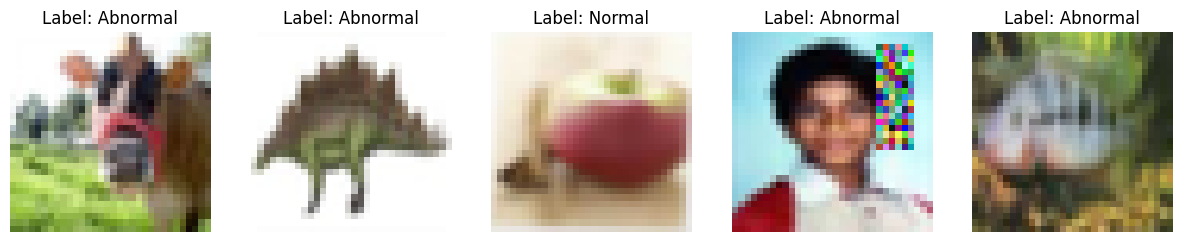

In [8]:
# Dataset with T-shirts (class 0) as normal and others as abnormal
train_dataset = Cifar100Custom(train=True, transform=transforms.ToTensor(), normal_class=0)

# Check the length of the dataset
print(f"Total number of samples in the dataset: {len(train_dataset)}")

# Show a few samples with their labels
show_samples(train_dataset, num_samples=5)

In [9]:
# def visualize_random_erasing(dataset, num_samples=5):
#     fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
#     for i in range(num_samples):
#         img, label = dataset[i]
        
#         # Convert to numpy for visualization (CHW to HWC)
#         img = img.permute(1, 2, 0).numpy()
        
#         # Show original image
#         axes[0, i].imshow((img * 255).astype(np.uint8))  # Denormalize
#         axes[0, i].set_title(f"Original: {label}")
#         axes[0, i].axis('off')

#         # Apply random erasing
#         erased_img = random_erasing(img.copy())
        
#         # Show image with random erasing
#         axes[1, i].imshow(erased_img.astype(np.uint8))
#         axes[1, i].set_title("With Random Erasing")
#         axes[1, i].axis('off')

#     plt.show()

# # Visualize 5 random samples from the dataset
# visualize_random_erasing(train_dataset, num_samples=5)

In [10]:
model = SSAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
device = torch.device('cuda')

In [12]:
model.to(device)

SSAE(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

Training loop

In [13]:
# List to store loss values for plotting
loss_values = []
val_loss_values = []

# variable initialization to store the best validation loss
best_val_loss = float('inf')

for epoch in range(350):
    model.train()  # model in training mode
    total_loss = 0
    
    # tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/350 (SSAE)")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        # Flatten the images for the autoencoder
        images = images.view(-1, 3*32*32)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = model.semi_supervised_loss(images, outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    
    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/10], Avg Loss: {avg_loss:.4f}")
    
    
    # --- Validation loop ---
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:

            val_images, val_labels = val_images.to(device), val_labels.to(device)
            
            # Flatten the validation images
            val_images = val_images.view(-1, 3*32*32)
            
            # Forward pass
            val_outputs = model(val_images)
            
            # Calculate validation loss
            val_loss = model.semi_supervised_loss(val_images, val_outputs, val_labels)
            total_val_loss += val_loss.item()
    
    # Calculate the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Print the average validation loss for the current epoch
    print(f"Epoch [{epoch+1}/10], Avg Validation Loss: {avg_val_loss:.4f}")
    
    # --- Model selection based on validation loss ---
    if avg_val_loss < best_val_loss and (epoch+1) % 5 == 0 :
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving the best model at epoch {epoch+1}.")
        torch.save(model.state_dict(), f'model_ssae_cifar100/best_model_epoch_{epoch+1}.pth')
    
    # Save the model after each epoch
    # torch.save(model.state_dict(), f'model_ssae_cifar100/ssae_cifar_epoch_{epoch+1}.pth')


Epoch 1/350 (SSAE): 100%|██████████| 782/782 [00:39<00:00, 19.90it/s, loss=1.73]


Epoch [1/10], Avg Loss: 1.6461
Epoch [1/10], Avg Validation Loss: 1.5222


Epoch 2/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.26it/s, loss=1.33]


Epoch [2/10], Avg Loss: 1.4765
Epoch [2/10], Avg Validation Loss: 1.4650


Epoch 3/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.87it/s, loss=1.06]


Epoch [3/10], Avg Loss: 1.4503
Epoch [3/10], Avg Validation Loss: 1.4537


Epoch 4/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.61it/s, loss=1.4] 


Epoch [4/10], Avg Loss: 1.4359
Epoch [4/10], Avg Validation Loss: 1.4348


Epoch 5/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.74it/s, loss=1.5] 


Epoch [5/10], Avg Loss: 1.4163
Epoch [5/10], Avg Validation Loss: 1.4173
Validation loss improved. Saving the best model at epoch 5.


Epoch 6/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.30it/s, loss=1.4] 


Epoch [6/10], Avg Loss: 1.4038
Epoch [6/10], Avg Validation Loss: 1.4066


Epoch 7/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.79it/s, loss=1.51]


Epoch [7/10], Avg Loss: 1.3949
Epoch [7/10], Avg Validation Loss: 1.3959


Epoch 8/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.42it/s, loss=1.46]


Epoch [8/10], Avg Loss: 1.3849
Epoch [8/10], Avg Validation Loss: 1.3901


Epoch 9/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.28it/s, loss=1.25]


Epoch [9/10], Avg Loss: 1.3761
Epoch [9/10], Avg Validation Loss: 1.3764


Epoch 10/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.55it/s, loss=1.28]


Epoch [10/10], Avg Loss: 1.3684
Epoch [10/10], Avg Validation Loss: 1.3719
Validation loss improved. Saving the best model at epoch 10.


Epoch 11/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.46it/s, loss=1.27]


Epoch [11/10], Avg Loss: 1.3604
Epoch [11/10], Avg Validation Loss: 1.3679


Epoch 12/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.84it/s, loss=1.11]


Epoch [12/10], Avg Loss: 1.3556
Epoch [12/10], Avg Validation Loss: 1.3628


Epoch 13/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.49it/s, loss=1.45]


Epoch [13/10], Avg Loss: 1.3516
Epoch [13/10], Avg Validation Loss: 1.3562


Epoch 14/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.08it/s, loss=1.26]


Epoch [14/10], Avg Loss: 1.3483
Epoch [14/10], Avg Validation Loss: 1.3549


Epoch 15/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.11it/s, loss=1.46]


Epoch [15/10], Avg Loss: 1.3438
Epoch [15/10], Avg Validation Loss: 1.3516
Validation loss improved. Saving the best model at epoch 15.


Epoch 16/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.69it/s, loss=1.37]


Epoch [16/10], Avg Loss: 1.3404
Epoch [16/10], Avg Validation Loss: 1.3457


Epoch 17/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.27it/s, loss=1.7] 


Epoch [17/10], Avg Loss: 1.3391
Epoch [17/10], Avg Validation Loss: 1.3433


Epoch 18/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.20it/s, loss=1.39]


Epoch [18/10], Avg Loss: 1.3361
Epoch [18/10], Avg Validation Loss: 1.3419


Epoch 19/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.40it/s, loss=1.33]


Epoch [19/10], Avg Loss: 1.3345
Epoch [19/10], Avg Validation Loss: 1.3368


Epoch 20/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.94it/s, loss=1.39]


Epoch [20/10], Avg Loss: 1.3318
Epoch [20/10], Avg Validation Loss: 1.3380
Validation loss improved. Saving the best model at epoch 20.


Epoch 21/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.24it/s, loss=1.75]


Epoch [21/10], Avg Loss: 1.3297
Epoch [21/10], Avg Validation Loss: 1.3339


Epoch 22/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.59it/s, loss=1.16]


Epoch [22/10], Avg Loss: 1.3274
Epoch [22/10], Avg Validation Loss: 1.3337


Epoch 23/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.14it/s, loss=1.56]


Epoch [23/10], Avg Loss: 1.3256
Epoch [23/10], Avg Validation Loss: 1.3321


Epoch 24/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, loss=1.26]


Epoch [24/10], Avg Loss: 1.3231
Epoch [24/10], Avg Validation Loss: 1.3338


Epoch 25/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.67it/s, loss=1.01]


Epoch [25/10], Avg Loss: 1.3212
Epoch [25/10], Avg Validation Loss: 1.3276
Validation loss improved. Saving the best model at epoch 25.


Epoch 26/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, loss=1.26]


Epoch [26/10], Avg Loss: 1.3220
Epoch [26/10], Avg Validation Loss: 1.3290


Epoch 27/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.92it/s, loss=1.17]


Epoch [27/10], Avg Loss: 1.3205
Epoch [27/10], Avg Validation Loss: 1.3234


Epoch 28/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.61it/s, loss=1.17]


Epoch [28/10], Avg Loss: 1.3167
Epoch [28/10], Avg Validation Loss: 1.3216


Epoch 29/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.24it/s, loss=1.32]


Epoch [29/10], Avg Loss: 1.3175
Epoch [29/10], Avg Validation Loss: 1.3212


Epoch 30/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.17it/s, loss=1.16]


Epoch [30/10], Avg Loss: 1.3134
Epoch [30/10], Avg Validation Loss: 1.3204
Validation loss improved. Saving the best model at epoch 30.


Epoch 31/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.83it/s, loss=1.15]


Epoch [31/10], Avg Loss: 1.3117
Epoch [31/10], Avg Validation Loss: 1.3214


Epoch 32/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.88it/s, loss=1.02]


Epoch [32/10], Avg Loss: 1.3110
Epoch [32/10], Avg Validation Loss: 1.3163


Epoch 33/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.24it/s, loss=1.19]


Epoch [33/10], Avg Loss: 1.3083
Epoch [33/10], Avg Validation Loss: 1.3184


Epoch 34/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 27.96it/s, loss=1.57]


Epoch [34/10], Avg Loss: 1.3086
Epoch [34/10], Avg Validation Loss: 1.3142


Epoch 35/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.07it/s, loss=1.25]


Epoch [35/10], Avg Loss: 1.3072
Epoch [35/10], Avg Validation Loss: 1.3153
Validation loss improved. Saving the best model at epoch 35.


Epoch 36/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.14it/s, loss=1.06] 


Epoch [36/10], Avg Loss: 1.3064
Epoch [36/10], Avg Validation Loss: 1.3121


Epoch 37/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.51it/s, loss=1.2] 


Epoch [37/10], Avg Loss: 1.3056
Epoch [37/10], Avg Validation Loss: 1.3125


Epoch 38/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.33it/s, loss=1.11]


Epoch [38/10], Avg Loss: 1.3050
Epoch [38/10], Avg Validation Loss: 1.3157


Epoch 39/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.57it/s, loss=1.41]


Epoch [39/10], Avg Loss: 1.3046
Epoch [39/10], Avg Validation Loss: 1.3101


Epoch 40/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.19it/s, loss=1.33]


Epoch [40/10], Avg Loss: 1.3024
Epoch [40/10], Avg Validation Loss: 1.3091
Validation loss improved. Saving the best model at epoch 40.


Epoch 41/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.98it/s, loss=1.08] 


Epoch [41/10], Avg Loss: 1.3001
Epoch [41/10], Avg Validation Loss: 1.3075


Epoch 42/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.10it/s, loss=1.34]


Epoch [42/10], Avg Loss: 1.2993
Epoch [42/10], Avg Validation Loss: 1.3067


Epoch 43/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, loss=1.37]


Epoch [43/10], Avg Loss: 1.3008
Epoch [43/10], Avg Validation Loss: 1.3066


Epoch 44/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.25it/s, loss=0.998]


Epoch [44/10], Avg Loss: 1.2991
Epoch [44/10], Avg Validation Loss: 1.3067


Epoch 45/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.14it/s, loss=1.16]


Epoch [45/10], Avg Loss: 1.2983
Epoch [45/10], Avg Validation Loss: 1.3046
Validation loss improved. Saving the best model at epoch 45.


Epoch 46/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.35it/s, loss=1.34]


Epoch [46/10], Avg Loss: 1.2970
Epoch [46/10], Avg Validation Loss: 1.3016


Epoch 47/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.75it/s, loss=1.22]


Epoch [47/10], Avg Loss: 1.2979
Epoch [47/10], Avg Validation Loss: 1.3049


Epoch 48/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.29it/s, loss=1.56]


Epoch [48/10], Avg Loss: 1.2960
Epoch [48/10], Avg Validation Loss: 1.3014


Epoch 49/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.46it/s, loss=1.44]


Epoch [49/10], Avg Loss: 1.2958
Epoch [49/10], Avg Validation Loss: 1.3015


Epoch 50/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.92it/s, loss=1.27]


Epoch [50/10], Avg Loss: 1.2947
Epoch [50/10], Avg Validation Loss: 1.2989
Validation loss improved. Saving the best model at epoch 50.


Epoch 51/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.56it/s, loss=1.26]


Epoch [51/10], Avg Loss: 1.2922
Epoch [51/10], Avg Validation Loss: 1.2988


Epoch 52/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.59it/s, loss=1.19]


Epoch [52/10], Avg Loss: 1.2936
Epoch [52/10], Avg Validation Loss: 1.2986


Epoch 53/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.68it/s, loss=1.06] 


Epoch [53/10], Avg Loss: 1.2920
Epoch [53/10], Avg Validation Loss: 1.2981


Epoch 54/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.56it/s, loss=1.24]


Epoch [54/10], Avg Loss: 1.2919
Epoch [54/10], Avg Validation Loss: 1.2993


Epoch 55/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.80it/s, loss=1.47]


Epoch [55/10], Avg Loss: 1.2910
Epoch [55/10], Avg Validation Loss: 1.2976
Validation loss improved. Saving the best model at epoch 55.


Epoch 56/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.53it/s, loss=1.18]


Epoch [56/10], Avg Loss: 1.2908
Epoch [56/10], Avg Validation Loss: 1.2968


Epoch 57/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.42it/s, loss=1.31]


Epoch [57/10], Avg Loss: 1.2899
Epoch [57/10], Avg Validation Loss: 1.2971


Epoch 58/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.80it/s, loss=1.26]


Epoch [58/10], Avg Loss: 1.2895
Epoch [58/10], Avg Validation Loss: 1.2950


Epoch 59/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.53it/s, loss=1.23]


Epoch [59/10], Avg Loss: 1.2897
Epoch [59/10], Avg Validation Loss: 1.2961


Epoch 60/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 27.95it/s, loss=1.27]


Epoch [60/10], Avg Loss: 1.2896
Epoch [60/10], Avg Validation Loss: 1.2953
Validation loss improved. Saving the best model at epoch 60.


Epoch 61/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.58it/s, loss=1.12]


Epoch [61/10], Avg Loss: 1.2877
Epoch [61/10], Avg Validation Loss: 1.2923


Epoch 62/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.64it/s, loss=1.18]


Epoch [62/10], Avg Loss: 1.2882
Epoch [62/10], Avg Validation Loss: 1.2940


Epoch 63/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.07it/s, loss=1.37]


Epoch [63/10], Avg Loss: 1.2870
Epoch [63/10], Avg Validation Loss: 1.2944


Epoch 64/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.12it/s, loss=1.15]


Epoch [64/10], Avg Loss: 1.2871
Epoch [64/10], Avg Validation Loss: 1.2936


Epoch 65/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.20it/s, loss=1.31]


Epoch [65/10], Avg Loss: 1.2858
Epoch [65/10], Avg Validation Loss: 1.2919
Validation loss improved. Saving the best model at epoch 65.


Epoch 66/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.50it/s, loss=1.01] 


Epoch [66/10], Avg Loss: 1.2862
Epoch [66/10], Avg Validation Loss: 1.2940


Epoch 67/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, loss=1.08]


Epoch [67/10], Avg Loss: 1.2840
Epoch [67/10], Avg Validation Loss: 1.2930


Epoch 68/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.87it/s, loss=1.82]


Epoch [68/10], Avg Loss: 1.2855
Epoch [68/10], Avg Validation Loss: 1.2914


Epoch 69/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.18it/s, loss=1.23]


Epoch [69/10], Avg Loss: 1.2833
Epoch [69/10], Avg Validation Loss: 1.2917


Epoch 70/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.14it/s, loss=1.23]


Epoch [70/10], Avg Loss: 1.2854
Epoch [70/10], Avg Validation Loss: 1.2925


Epoch 71/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.66it/s, loss=1.16]


Epoch [71/10], Avg Loss: 1.2830
Epoch [71/10], Avg Validation Loss: 1.2906


Epoch 72/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.86it/s, loss=1.06]


Epoch [72/10], Avg Loss: 1.2838
Epoch [72/10], Avg Validation Loss: 1.2899


Epoch 73/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, loss=1.1] 


Epoch [73/10], Avg Loss: 1.2811
Epoch [73/10], Avg Validation Loss: 1.2905


Epoch 74/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.86it/s, loss=1.07] 


Epoch [74/10], Avg Loss: 1.2815
Epoch [74/10], Avg Validation Loss: 1.2894


Epoch 75/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.24it/s, loss=1.37]


Epoch [75/10], Avg Loss: 1.2817
Epoch [75/10], Avg Validation Loss: 1.2880
Validation loss improved. Saving the best model at epoch 75.


Epoch 76/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.33it/s, loss=0.893]


Epoch [76/10], Avg Loss: 1.2807
Epoch [76/10], Avg Validation Loss: 1.2895


Epoch 77/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.83it/s, loss=1.72] 


Epoch [77/10], Avg Loss: 1.2810
Epoch [77/10], Avg Validation Loss: 1.2898


Epoch 78/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.72it/s, loss=1.3] 


Epoch [78/10], Avg Loss: 1.2823
Epoch [78/10], Avg Validation Loss: 1.2889


Epoch 79/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, loss=1.21]


Epoch [79/10], Avg Loss: 1.2822
Epoch [79/10], Avg Validation Loss: 1.2870


Epoch 80/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.33it/s, loss=1.15]


Epoch [80/10], Avg Loss: 1.2788
Epoch [80/10], Avg Validation Loss: 1.2857
Validation loss improved. Saving the best model at epoch 80.


Epoch 81/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.43it/s, loss=1.17]


Epoch [81/10], Avg Loss: 1.2802
Epoch [81/10], Avg Validation Loss: 1.2843


Epoch 82/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.30it/s, loss=1.59] 


Epoch [82/10], Avg Loss: 1.2804
Epoch [82/10], Avg Validation Loss: 1.2857


Epoch 83/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.82it/s, loss=1.29]


Epoch [83/10], Avg Loss: 1.2801
Epoch [83/10], Avg Validation Loss: 1.2866


Epoch 84/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.06it/s, loss=1.2] 


Epoch [84/10], Avg Loss: 1.2792
Epoch [84/10], Avg Validation Loss: 1.2847


Epoch 85/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.77it/s, loss=1.09] 


Epoch [85/10], Avg Loss: 1.2780
Epoch [85/10], Avg Validation Loss: 1.2852
Validation loss improved. Saving the best model at epoch 85.


Epoch 86/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.24it/s, loss=1.43]


Epoch [86/10], Avg Loss: 1.2790
Epoch [86/10], Avg Validation Loss: 1.2848


Epoch 87/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 27.95it/s, loss=1.28]


Epoch [87/10], Avg Loss: 1.2780
Epoch [87/10], Avg Validation Loss: 1.2850


Epoch 88/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.94it/s, loss=1.49]


Epoch [88/10], Avg Loss: 1.2778
Epoch [88/10], Avg Validation Loss: 1.2855


Epoch 89/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.51it/s, loss=1.35] 


Epoch [89/10], Avg Loss: 1.2782
Epoch [89/10], Avg Validation Loss: 1.2854


Epoch 90/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.50it/s, loss=1.21]


Epoch [90/10], Avg Loss: 1.2774
Epoch [90/10], Avg Validation Loss: 1.2872


Epoch 91/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.60it/s, loss=1.29] 


Epoch [91/10], Avg Loss: 1.2748
Epoch [91/10], Avg Validation Loss: 1.2872


Epoch 92/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.74it/s, loss=1.69]


Epoch [92/10], Avg Loss: 1.2773
Epoch [92/10], Avg Validation Loss: 1.2819


Epoch 93/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.58it/s, loss=1.21] 


Epoch [93/10], Avg Loss: 1.2763
Epoch [93/10], Avg Validation Loss: 1.2827


Epoch 94/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.28it/s, loss=1.46] 


Epoch [94/10], Avg Loss: 1.2750
Epoch [94/10], Avg Validation Loss: 1.2839


Epoch 95/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.14it/s, loss=1.35]


Epoch [95/10], Avg Loss: 1.2757
Epoch [95/10], Avg Validation Loss: 1.2821
Validation loss improved. Saving the best model at epoch 95.


Epoch 96/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.08it/s, loss=1.31]


Epoch [96/10], Avg Loss: 1.2749
Epoch [96/10], Avg Validation Loss: 1.2849


Epoch 97/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.93it/s, loss=1.56]


Epoch [97/10], Avg Loss: 1.2758
Epoch [97/10], Avg Validation Loss: 1.2801


Epoch 98/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.08it/s, loss=1.34]


Epoch [98/10], Avg Loss: 1.2737
Epoch [98/10], Avg Validation Loss: 1.2834


Epoch 99/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.06it/s, loss=1.28]


Epoch [99/10], Avg Loss: 1.2746
Epoch [99/10], Avg Validation Loss: 1.2785


Epoch 100/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.40it/s, loss=0.961]


Epoch [100/10], Avg Loss: 1.2740
Epoch [100/10], Avg Validation Loss: 1.2826


Epoch 101/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.38it/s, loss=1.09] 


Epoch [101/10], Avg Loss: 1.2750
Epoch [101/10], Avg Validation Loss: 1.2815


Epoch 102/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.84it/s, loss=1.18]


Epoch [102/10], Avg Loss: 1.2742
Epoch [102/10], Avg Validation Loss: 1.2805


Epoch 103/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.74it/s, loss=1.21]


Epoch [103/10], Avg Loss: 1.2732
Epoch [103/10], Avg Validation Loss: 1.2815


Epoch 104/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.32it/s, loss=1.47]


Epoch [104/10], Avg Loss: 1.2751
Epoch [104/10], Avg Validation Loss: 1.2822


Epoch 105/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.35it/s, loss=1.67]


Epoch [105/10], Avg Loss: 1.2757
Epoch [105/10], Avg Validation Loss: 1.2777
Validation loss improved. Saving the best model at epoch 105.


Epoch 106/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.70it/s, loss=1.55]


Epoch [106/10], Avg Loss: 1.2736
Epoch [106/10], Avg Validation Loss: 1.2807


Epoch 107/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.06it/s, loss=1.29] 


Epoch [107/10], Avg Loss: 1.2730
Epoch [107/10], Avg Validation Loss: 1.2788


Epoch 108/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.90it/s, loss=1.64]


Epoch [108/10], Avg Loss: 1.2747
Epoch [108/10], Avg Validation Loss: 1.2800


Epoch 109/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.36it/s, loss=1.11] 


Epoch [109/10], Avg Loss: 1.2727
Epoch [109/10], Avg Validation Loss: 1.2790


Epoch 110/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.31it/s, loss=1.37]


Epoch [110/10], Avg Loss: 1.2734
Epoch [110/10], Avg Validation Loss: 1.2764
Validation loss improved. Saving the best model at epoch 110.


Epoch 111/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.10it/s, loss=1.19]


Epoch [111/10], Avg Loss: 1.2716
Epoch [111/10], Avg Validation Loss: 1.2812


Epoch 112/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.66it/s, loss=0.943]


Epoch [112/10], Avg Loss: 1.2722
Epoch [112/10], Avg Validation Loss: 1.2785


Epoch 113/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.86it/s, loss=0.995]


Epoch [113/10], Avg Loss: 1.2712
Epoch [113/10], Avg Validation Loss: 1.2793


Epoch 114/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.85it/s, loss=1.21]


Epoch [114/10], Avg Loss: 1.2720
Epoch [114/10], Avg Validation Loss: 1.2779


Epoch 115/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.31it/s, loss=1.27]


Epoch [115/10], Avg Loss: 1.2712
Epoch [115/10], Avg Validation Loss: 1.2781


Epoch 116/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.83it/s, loss=1.2] 


Epoch [116/10], Avg Loss: 1.2717
Epoch [116/10], Avg Validation Loss: 1.2781


Epoch 117/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.24it/s, loss=1.29]


Epoch [117/10], Avg Loss: 1.2705
Epoch [117/10], Avg Validation Loss: 1.2785


Epoch 118/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.77it/s, loss=1.17] 


Epoch [118/10], Avg Loss: 1.2709
Epoch [118/10], Avg Validation Loss: 1.2790


Epoch 119/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.29it/s, loss=1.05]


Epoch [119/10], Avg Loss: 1.2708
Epoch [119/10], Avg Validation Loss: 1.2758


Epoch 120/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.79it/s, loss=1.22]


Epoch [120/10], Avg Loss: 1.2709
Epoch [120/10], Avg Validation Loss: 1.2801


Epoch 121/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.09it/s, loss=1.11]


Epoch [121/10], Avg Loss: 1.2701
Epoch [121/10], Avg Validation Loss: 1.2812


Epoch 122/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.77it/s, loss=1.05]


Epoch [122/10], Avg Loss: 1.2698
Epoch [122/10], Avg Validation Loss: 1.2735


Epoch 123/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.05it/s, loss=1.54]


Epoch [123/10], Avg Loss: 1.2715
Epoch [123/10], Avg Validation Loss: 1.2764


Epoch 124/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.29it/s, loss=1.21]


Epoch [124/10], Avg Loss: 1.2691
Epoch [124/10], Avg Validation Loss: 1.2744


Epoch 125/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.21it/s, loss=1.19]


Epoch [125/10], Avg Loss: 1.2685
Epoch [125/10], Avg Validation Loss: 1.2745
Validation loss improved. Saving the best model at epoch 125.


Epoch 126/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.56it/s, loss=1.82]


Epoch [126/10], Avg Loss: 1.2701
Epoch [126/10], Avg Validation Loss: 1.2770


Epoch 127/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.79it/s, loss=1.35]


Epoch [127/10], Avg Loss: 1.2697
Epoch [127/10], Avg Validation Loss: 1.2780


Epoch 128/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, loss=1.42]


Epoch [128/10], Avg Loss: 1.2698
Epoch [128/10], Avg Validation Loss: 1.2778


Epoch 129/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.59it/s, loss=1.26]


Epoch [129/10], Avg Loss: 1.2694
Epoch [129/10], Avg Validation Loss: 1.2741


Epoch 130/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.97it/s, loss=1.35] 


Epoch [130/10], Avg Loss: 1.2691
Epoch [130/10], Avg Validation Loss: 1.2774


Epoch 131/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.13it/s, loss=1.23]


Epoch [131/10], Avg Loss: 1.2687
Epoch [131/10], Avg Validation Loss: 1.2755


Epoch 132/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.16it/s, loss=1.21]


Epoch [132/10], Avg Loss: 1.2694
Epoch [132/10], Avg Validation Loss: 1.2788


Epoch 133/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, loss=1.35]


Epoch [133/10], Avg Loss: 1.2685
Epoch [133/10], Avg Validation Loss: 1.2761


Epoch 134/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.39it/s, loss=1.4] 


Epoch [134/10], Avg Loss: 1.2679
Epoch [134/10], Avg Validation Loss: 1.2741


Epoch 135/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.71it/s, loss=1.46]


Epoch [135/10], Avg Loss: 1.2675
Epoch [135/10], Avg Validation Loss: 1.2758


Epoch 136/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.74it/s, loss=1.34]


Epoch [136/10], Avg Loss: 1.2680
Epoch [136/10], Avg Validation Loss: 1.2761


Epoch 137/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.23it/s, loss=1.25]


Epoch [137/10], Avg Loss: 1.2664
Epoch [137/10], Avg Validation Loss: 1.2713


Epoch 138/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.67it/s, loss=1.5] 


Epoch [138/10], Avg Loss: 1.2677
Epoch [138/10], Avg Validation Loss: 1.2745


Epoch 139/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.28it/s, loss=1.2] 


Epoch [139/10], Avg Loss: 1.2664
Epoch [139/10], Avg Validation Loss: 1.2748


Epoch 140/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.87it/s, loss=1.27]


Epoch [140/10], Avg Loss: 1.2679
Epoch [140/10], Avg Validation Loss: 1.2768


Epoch 141/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.55it/s, loss=1.1] 


Epoch [141/10], Avg Loss: 1.2675
Epoch [141/10], Avg Validation Loss: 1.2782


Epoch 142/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.70it/s, loss=1.39]


Epoch [142/10], Avg Loss: 1.2680
Epoch [142/10], Avg Validation Loss: 1.2743


Epoch 143/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.96it/s, loss=1.53]


Epoch [143/10], Avg Loss: 1.2677
Epoch [143/10], Avg Validation Loss: 1.2720


Epoch 144/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.95it/s, loss=1.43]


Epoch [144/10], Avg Loss: 1.2656
Epoch [144/10], Avg Validation Loss: 1.2706


Epoch 145/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.83it/s, loss=1.41]


Epoch [145/10], Avg Loss: 1.2663
Epoch [145/10], Avg Validation Loss: 1.2777


Epoch 146/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.49it/s, loss=1.1] 


Epoch [146/10], Avg Loss: 1.2675
Epoch [146/10], Avg Validation Loss: 1.2723


Epoch 147/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.56it/s, loss=1.16]


Epoch [147/10], Avg Loss: 1.2658
Epoch [147/10], Avg Validation Loss: 1.2716


Epoch 148/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.93it/s, loss=1.29]


Epoch [148/10], Avg Loss: 1.2667
Epoch [148/10], Avg Validation Loss: 1.2718


Epoch 149/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.90it/s, loss=1.28]


Epoch [149/10], Avg Loss: 1.2661
Epoch [149/10], Avg Validation Loss: 1.2759


Epoch 150/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.68it/s, loss=0.981]


Epoch [150/10], Avg Loss: 1.2663
Epoch [150/10], Avg Validation Loss: 1.2744
Validation loss improved. Saving the best model at epoch 150.


Epoch 151/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.86it/s, loss=1.29]


Epoch [151/10], Avg Loss: 1.2653
Epoch [151/10], Avg Validation Loss: 1.2722


Epoch 152/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.72it/s, loss=1.14]


Epoch [152/10], Avg Loss: 1.2657
Epoch [152/10], Avg Validation Loss: 1.2720


Epoch 153/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.31it/s, loss=1.15]


Epoch [153/10], Avg Loss: 1.2653
Epoch [153/10], Avg Validation Loss: 1.2718


Epoch 154/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.57it/s, loss=1.05]


Epoch [154/10], Avg Loss: 1.2646
Epoch [154/10], Avg Validation Loss: 1.2732


Epoch 155/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.50it/s, loss=1.34]


Epoch [155/10], Avg Loss: 1.2665
Epoch [155/10], Avg Validation Loss: 1.2700
Validation loss improved. Saving the best model at epoch 155.


Epoch 156/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.79it/s, loss=1.58] 


Epoch [156/10], Avg Loss: 1.2655
Epoch [156/10], Avg Validation Loss: 1.2718


Epoch 157/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, loss=1.58] 


Epoch [157/10], Avg Loss: 1.2645
Epoch [157/10], Avg Validation Loss: 1.2737


Epoch 158/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.34it/s, loss=1.35]


Epoch [158/10], Avg Loss: 1.2648
Epoch [158/10], Avg Validation Loss: 1.2724


Epoch 159/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.69it/s, loss=1.11]


Epoch [159/10], Avg Loss: 1.2633
Epoch [159/10], Avg Validation Loss: 1.2727


Epoch 160/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.92it/s, loss=1.43] 


Epoch [160/10], Avg Loss: 1.2622
Epoch [160/10], Avg Validation Loss: 1.2690
Validation loss improved. Saving the best model at epoch 160.


Epoch 161/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.79it/s, loss=1.14]


Epoch [161/10], Avg Loss: 1.2629
Epoch [161/10], Avg Validation Loss: 1.2727


Epoch 162/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.86it/s, loss=1.08]


Epoch [162/10], Avg Loss: 1.2627
Epoch [162/10], Avg Validation Loss: 1.2679


Epoch 163/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.34it/s, loss=1.33]


Epoch [163/10], Avg Loss: 1.2631
Epoch [163/10], Avg Validation Loss: 1.2697


Epoch 164/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.54it/s, loss=0.939]


Epoch [164/10], Avg Loss: 1.2632
Epoch [164/10], Avg Validation Loss: 1.2693


Epoch 165/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.65it/s, loss=1.63]


Epoch [165/10], Avg Loss: 1.2644
Epoch [165/10], Avg Validation Loss: 1.2677
Validation loss improved. Saving the best model at epoch 165.


Epoch 166/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.12it/s, loss=1.37] 


Epoch [166/10], Avg Loss: 1.2630
Epoch [166/10], Avg Validation Loss: 1.2686


Epoch 167/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.21it/s, loss=0.982]


Epoch [167/10], Avg Loss: 1.2624
Epoch [167/10], Avg Validation Loss: 1.2718


Epoch 168/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.62it/s, loss=1.56] 


Epoch [168/10], Avg Loss: 1.2642
Epoch [168/10], Avg Validation Loss: 1.2699


Epoch 169/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.45it/s, loss=1.53]


Epoch [169/10], Avg Loss: 1.2626
Epoch [169/10], Avg Validation Loss: 1.2694


Epoch 170/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.94it/s, loss=1.55] 


Epoch [170/10], Avg Loss: 1.2626
Epoch [170/10], Avg Validation Loss: 1.2713


Epoch 171/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.91it/s, loss=1.58]


Epoch [171/10], Avg Loss: 1.2628
Epoch [171/10], Avg Validation Loss: 1.2705


Epoch 172/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.49it/s, loss=1.42]


Epoch [172/10], Avg Loss: 1.2627
Epoch [172/10], Avg Validation Loss: 1.2707


Epoch 173/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.74it/s, loss=1.32]


Epoch [173/10], Avg Loss: 1.2621
Epoch [173/10], Avg Validation Loss: 1.2673


Epoch 174/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.49it/s, loss=1.25]


Epoch [174/10], Avg Loss: 1.2621
Epoch [174/10], Avg Validation Loss: 1.2707


Epoch 175/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.15it/s, loss=1.34] 


Epoch [175/10], Avg Loss: 1.2634
Epoch [175/10], Avg Validation Loss: 1.2688


Epoch 176/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.77it/s, loss=1.39] 


Epoch [176/10], Avg Loss: 1.2625
Epoch [176/10], Avg Validation Loss: 1.2687


Epoch 177/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.65it/s, loss=1.42]


Epoch [177/10], Avg Loss: 1.2623
Epoch [177/10], Avg Validation Loss: 1.2685


Epoch 178/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, loss=1.17] 


Epoch [178/10], Avg Loss: 1.2625
Epoch [178/10], Avg Validation Loss: 1.2709


Epoch 179/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.21it/s, loss=1.26]


Epoch [179/10], Avg Loss: 1.2636
Epoch [179/10], Avg Validation Loss: 1.2679


Epoch 180/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.50it/s, loss=1.32] 


Epoch [180/10], Avg Loss: 1.2628
Epoch [180/10], Avg Validation Loss: 1.2695


Epoch 181/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.55it/s, loss=1.5] 


Epoch [181/10], Avg Loss: 1.2638
Epoch [181/10], Avg Validation Loss: 1.2705


Epoch 182/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.27it/s, loss=1.18] 


Epoch [182/10], Avg Loss: 1.2618
Epoch [182/10], Avg Validation Loss: 1.2698


Epoch 183/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.11it/s, loss=0.936]


Epoch [183/10], Avg Loss: 1.2611
Epoch [183/10], Avg Validation Loss: 1.2685


Epoch 184/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.01it/s, loss=1.26]


Epoch [184/10], Avg Loss: 1.2619
Epoch [184/10], Avg Validation Loss: 1.2682


Epoch 185/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 21.87it/s, loss=1.01] 


Epoch [185/10], Avg Loss: 1.2620
Epoch [185/10], Avg Validation Loss: 1.2705


Epoch 186/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.20it/s, loss=1.4] 


Epoch [186/10], Avg Loss: 1.2632
Epoch [186/10], Avg Validation Loss: 1.2718


Epoch 187/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.12it/s, loss=1.15] 


Epoch [187/10], Avg Loss: 1.2604
Epoch [187/10], Avg Validation Loss: 1.2674


Epoch 188/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 26.06it/s, loss=1.15] 


Epoch [188/10], Avg Loss: 1.2622
Epoch [188/10], Avg Validation Loss: 1.2671


Epoch 189/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.17it/s, loss=1.59] 


Epoch [189/10], Avg Loss: 1.2618
Epoch [189/10], Avg Validation Loss: 1.2713


Epoch 190/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.31it/s, loss=1.14]


Epoch [190/10], Avg Loss: 1.2612
Epoch [190/10], Avg Validation Loss: 1.2707


Epoch 191/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.65it/s, loss=1.23] 


Epoch [191/10], Avg Loss: 1.2622
Epoch [191/10], Avg Validation Loss: 1.2705


Epoch 192/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.19it/s, loss=1.46]


Epoch [192/10], Avg Loss: 1.2619
Epoch [192/10], Avg Validation Loss: 1.2693


Epoch 193/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.33it/s, loss=1.37] 


Epoch [193/10], Avg Loss: 1.2616
Epoch [193/10], Avg Validation Loss: 1.2698


Epoch 194/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.12it/s, loss=1.28]


Epoch [194/10], Avg Loss: 1.2618
Epoch [194/10], Avg Validation Loss: 1.2655


Epoch 195/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.09it/s, loss=1.17]


Epoch [195/10], Avg Loss: 1.2620
Epoch [195/10], Avg Validation Loss: 1.2685


Epoch 196/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.43it/s, loss=1.66] 


Epoch [196/10], Avg Loss: 1.2631
Epoch [196/10], Avg Validation Loss: 1.2692


Epoch 197/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.34it/s, loss=1.29]


Epoch [197/10], Avg Loss: 1.2628
Epoch [197/10], Avg Validation Loss: 1.2639


Epoch 198/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.58it/s, loss=1.02] 


Epoch [198/10], Avg Loss: 1.2614
Epoch [198/10], Avg Validation Loss: 1.2681


Epoch 199/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.90it/s, loss=1.42] 


Epoch [199/10], Avg Loss: 1.2616
Epoch [199/10], Avg Validation Loss: 1.2656


Epoch 200/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.31it/s, loss=1.37]


Epoch [200/10], Avg Loss: 1.2605
Epoch [200/10], Avg Validation Loss: 1.2652
Validation loss improved. Saving the best model at epoch 200.


Epoch 201/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.30it/s, loss=1.25]


Epoch [201/10], Avg Loss: 1.2616
Epoch [201/10], Avg Validation Loss: 1.2656


Epoch 202/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.36it/s, loss=1.06]


Epoch [202/10], Avg Loss: 1.2604
Epoch [202/10], Avg Validation Loss: 1.2693


Epoch 203/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.30it/s, loss=1.09]


Epoch [203/10], Avg Loss: 1.2596
Epoch [203/10], Avg Validation Loss: 1.2702


Epoch 204/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.84it/s, loss=1.29]


Epoch [204/10], Avg Loss: 1.2602
Epoch [204/10], Avg Validation Loss: 1.2676


Epoch 205/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.43it/s, loss=1.3] 


Epoch [205/10], Avg Loss: 1.2626
Epoch [205/10], Avg Validation Loss: 1.2701


Epoch 206/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.54it/s, loss=0.805]


Epoch [206/10], Avg Loss: 1.2611
Epoch [206/10], Avg Validation Loss: 1.2667


Epoch 207/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.63it/s, loss=1.15] 


Epoch [207/10], Avg Loss: 1.2604
Epoch [207/10], Avg Validation Loss: 1.2656


Epoch 208/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.09it/s, loss=0.989]


Epoch [208/10], Avg Loss: 1.2600
Epoch [208/10], Avg Validation Loss: 1.2663


Epoch 209/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.89it/s, loss=1.09]


Epoch [209/10], Avg Loss: 1.2593
Epoch [209/10], Avg Validation Loss: 1.2681


Epoch 210/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 21.81it/s, loss=1.32]


Epoch [210/10], Avg Loss: 1.2595
Epoch [210/10], Avg Validation Loss: 1.2664


Epoch 211/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.41it/s, loss=1.39]


Epoch [211/10], Avg Loss: 1.2586
Epoch [211/10], Avg Validation Loss: 1.2644


Epoch 212/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.03it/s, loss=1.3] 


Epoch [212/10], Avg Loss: 1.2595
Epoch [212/10], Avg Validation Loss: 1.2662


Epoch 213/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.20it/s, loss=1.39]


Epoch [213/10], Avg Loss: 1.2593
Epoch [213/10], Avg Validation Loss: 1.2643


Epoch 214/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.71it/s, loss=1.36] 


Epoch [214/10], Avg Loss: 1.2601
Epoch [214/10], Avg Validation Loss: 1.2689


Epoch 215/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.11it/s, loss=1.33] 


Epoch [215/10], Avg Loss: 1.2590
Epoch [215/10], Avg Validation Loss: 1.2678


Epoch 216/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.16it/s, loss=1.4] 


Epoch [216/10], Avg Loss: 1.2596
Epoch [216/10], Avg Validation Loss: 1.2663


Epoch 217/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.13it/s, loss=0.999]


Epoch [217/10], Avg Loss: 1.2593
Epoch [217/10], Avg Validation Loss: 1.2673


Epoch 218/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.96it/s, loss=1.45]


Epoch [218/10], Avg Loss: 1.2608
Epoch [218/10], Avg Validation Loss: 1.2653


Epoch 219/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.39it/s, loss=1.13]


Epoch [219/10], Avg Loss: 1.2599
Epoch [219/10], Avg Validation Loss: 1.2664


Epoch 220/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.21it/s, loss=1.03] 


Epoch [220/10], Avg Loss: 1.2583
Epoch [220/10], Avg Validation Loss: 1.2665


Epoch 221/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.62it/s, loss=1.06]


Epoch [221/10], Avg Loss: 1.2589
Epoch [221/10], Avg Validation Loss: 1.2648


Epoch 222/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.26it/s, loss=1.21] 


Epoch [222/10], Avg Loss: 1.2593
Epoch [222/10], Avg Validation Loss: 1.2680


Epoch 223/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.83it/s, loss=1.27]


Epoch [223/10], Avg Loss: 1.2588
Epoch [223/10], Avg Validation Loss: 1.2669


Epoch 224/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 22.01it/s, loss=1.49]


Epoch [224/10], Avg Loss: 1.2592
Epoch [224/10], Avg Validation Loss: 1.2646


Epoch 225/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.14it/s, loss=1.08] 


Epoch [225/10], Avg Loss: 1.2578
Epoch [225/10], Avg Validation Loss: 1.2639
Validation loss improved. Saving the best model at epoch 225.


Epoch 226/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.19it/s, loss=1.09]


Epoch [226/10], Avg Loss: 1.2593
Epoch [226/10], Avg Validation Loss: 1.2681


Epoch 227/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, loss=1.39]


Epoch [227/10], Avg Loss: 1.2608
Epoch [227/10], Avg Validation Loss: 1.2644


Epoch 228/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.06it/s, loss=1.47]


Epoch [228/10], Avg Loss: 1.2591
Epoch [228/10], Avg Validation Loss: 1.2621


Epoch 229/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.12it/s, loss=1.15]


Epoch [229/10], Avg Loss: 1.2592
Epoch [229/10], Avg Validation Loss: 1.2671


Epoch 230/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.88it/s, loss=1.54] 


Epoch [230/10], Avg Loss: 1.2592
Epoch [230/10], Avg Validation Loss: 1.2644


Epoch 231/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.86it/s, loss=1.2] 


Epoch [231/10], Avg Loss: 1.2587
Epoch [231/10], Avg Validation Loss: 1.2694


Epoch 232/350 (SSAE): 100%|██████████| 782/782 [00:35<00:00, 21.97it/s, loss=1.43]


Epoch [232/10], Avg Loss: 1.2574
Epoch [232/10], Avg Validation Loss: 1.2640


Epoch 233/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.66it/s, loss=1.08] 


Epoch [233/10], Avg Loss: 1.2585
Epoch [233/10], Avg Validation Loss: 1.2654


Epoch 234/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.41it/s, loss=1.11]


Epoch [234/10], Avg Loss: 1.2585
Epoch [234/10], Avg Validation Loss: 1.2626


Epoch 235/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.57it/s, loss=1.34] 


Epoch [235/10], Avg Loss: 1.2574
Epoch [235/10], Avg Validation Loss: 1.2661


Epoch 236/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 24.17it/s, loss=1.08] 


Epoch [236/10], Avg Loss: 1.2570
Epoch [236/10], Avg Validation Loss: 1.2649


Epoch 237/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.73it/s, loss=1.33]


Epoch [237/10], Avg Loss: 1.2581
Epoch [237/10], Avg Validation Loss: 1.2664


Epoch 238/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.57it/s, loss=1.23]


Epoch [238/10], Avg Loss: 1.2585
Epoch [238/10], Avg Validation Loss: 1.2656


Epoch 239/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.80it/s, loss=1.11]


Epoch [239/10], Avg Loss: 1.2579
Epoch [239/10], Avg Validation Loss: 1.2679


Epoch 240/350 (SSAE): 100%|██████████| 782/782 [00:32<00:00, 23.93it/s, loss=1.13]


Epoch [240/10], Avg Loss: 1.2586
Epoch [240/10], Avg Validation Loss: 1.2645


Epoch 241/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.39it/s, loss=1.28]


Epoch [241/10], Avg Loss: 1.2577
Epoch [241/10], Avg Validation Loss: 1.2658


Epoch 242/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.40it/s, loss=1.14]


Epoch [242/10], Avg Loss: 1.2580
Epoch [242/10], Avg Validation Loss: 1.2659


Epoch 243/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.04it/s, loss=1.11]


Epoch [243/10], Avg Loss: 1.2573
Epoch [243/10], Avg Validation Loss: 1.2665


Epoch 244/350 (SSAE): 100%|██████████| 782/782 [00:33<00:00, 23.39it/s, loss=1.11]


Epoch [244/10], Avg Loss: 1.2589
Epoch [244/10], Avg Validation Loss: 1.2649


Epoch 245/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.34it/s, loss=1.18]


Epoch [245/10], Avg Loss: 1.2579
Epoch [245/10], Avg Validation Loss: 1.2651


Epoch 246/350 (SSAE): 100%|██████████| 782/782 [00:34<00:00, 22.83it/s, loss=1.43]


Epoch [246/10], Avg Loss: 1.2582
Epoch [246/10], Avg Validation Loss: 1.2666


Epoch 247/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.51it/s, loss=1.26]


Epoch [247/10], Avg Loss: 1.2571
Epoch [247/10], Avg Validation Loss: 1.2657


Epoch 248/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.84it/s, loss=1.23]


Epoch [248/10], Avg Loss: 1.2579
Epoch [248/10], Avg Validation Loss: 1.2655


Epoch 249/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.71it/s, loss=1.22]


Epoch [249/10], Avg Loss: 1.2584
Epoch [249/10], Avg Validation Loss: 1.2634


Epoch 250/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 24.98it/s, loss=1.49]


Epoch [250/10], Avg Loss: 1.2583
Epoch [250/10], Avg Validation Loss: 1.2655


Epoch 251/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.76it/s, loss=1.28]


Epoch [251/10], Avg Loss: 1.2581
Epoch [251/10], Avg Validation Loss: 1.2678


Epoch 252/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.20it/s, loss=1.25]


Epoch [252/10], Avg Loss: 1.2579
Epoch [252/10], Avg Validation Loss: 1.2631


Epoch 253/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.51it/s, loss=0.978]


Epoch [253/10], Avg Loss: 1.2593
Epoch [253/10], Avg Validation Loss: 1.2632


Epoch 254/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.02it/s, loss=1.51]


Epoch [254/10], Avg Loss: 1.2578
Epoch [254/10], Avg Validation Loss: 1.2610


Epoch 255/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.37it/s, loss=1.29]


Epoch [255/10], Avg Loss: 1.2573
Epoch [255/10], Avg Validation Loss: 1.2641


Epoch 256/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.03it/s, loss=1.11]


Epoch [256/10], Avg Loss: 1.2587
Epoch [256/10], Avg Validation Loss: 1.2651


Epoch 257/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.83it/s, loss=1.07]


Epoch [257/10], Avg Loss: 1.2576
Epoch [257/10], Avg Validation Loss: 1.2656


Epoch 258/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.20it/s, loss=1.21]


Epoch [258/10], Avg Loss: 1.2579
Epoch [258/10], Avg Validation Loss: 1.2633


Epoch 259/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.12it/s, loss=1.11]


Epoch [259/10], Avg Loss: 1.2579
Epoch [259/10], Avg Validation Loss: 1.2640


Epoch 260/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.77it/s, loss=1.12]


Epoch [260/10], Avg Loss: 1.2570
Epoch [260/10], Avg Validation Loss: 1.2668


Epoch 261/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 28.96it/s, loss=1.2] 


Epoch [261/10], Avg Loss: 1.2571
Epoch [261/10], Avg Validation Loss: 1.2663


Epoch 262/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.66it/s, loss=1.07]


Epoch [262/10], Avg Loss: 1.2569
Epoch [262/10], Avg Validation Loss: 1.2629


Epoch 263/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.67it/s, loss=1.42]


Epoch [263/10], Avg Loss: 1.2586
Epoch [263/10], Avg Validation Loss: 1.2667


Epoch 264/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.67it/s, loss=1.18] 


Epoch [264/10], Avg Loss: 1.2573
Epoch [264/10], Avg Validation Loss: 1.2637


Epoch 265/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.21it/s, loss=1.26]


Epoch [265/10], Avg Loss: 1.2589
Epoch [265/10], Avg Validation Loss: 1.2635
Validation loss improved. Saving the best model at epoch 265.


Epoch 266/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.72it/s, loss=1.33] 


Epoch [266/10], Avg Loss: 1.2577
Epoch [266/10], Avg Validation Loss: 1.2654


Epoch 267/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 30.03it/s, loss=1.36] 


Epoch [267/10], Avg Loss: 1.2574
Epoch [267/10], Avg Validation Loss: 1.2614


Epoch 268/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.69it/s, loss=1.28]


Epoch [268/10], Avg Loss: 1.2574
Epoch [268/10], Avg Validation Loss: 1.2656


Epoch 269/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.60it/s, loss=0.996]


Epoch [269/10], Avg Loss: 1.2585
Epoch [269/10], Avg Validation Loss: 1.2659


Epoch 270/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.60it/s, loss=1.3] 


Epoch [270/10], Avg Loss: 1.2578
Epoch [270/10], Avg Validation Loss: 1.2640


Epoch 271/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.69it/s, loss=1.14]


Epoch [271/10], Avg Loss: 1.2574
Epoch [271/10], Avg Validation Loss: 1.2648


Epoch 272/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.84it/s, loss=1.65] 


Epoch [272/10], Avg Loss: 1.2581
Epoch [272/10], Avg Validation Loss: 1.2667


Epoch 273/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.82it/s, loss=1.52]


Epoch [273/10], Avg Loss: 1.2565
Epoch [273/10], Avg Validation Loss: 1.2641


Epoch 274/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.33it/s, loss=1.4] 


Epoch [274/10], Avg Loss: 1.2575
Epoch [274/10], Avg Validation Loss: 1.2624


Epoch 275/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.64it/s, loss=0.946]


Epoch [275/10], Avg Loss: 1.2564
Epoch [275/10], Avg Validation Loss: 1.2626
Validation loss improved. Saving the best model at epoch 275.


Epoch 276/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.12it/s, loss=1.17]


Epoch [276/10], Avg Loss: 1.2573
Epoch [276/10], Avg Validation Loss: 1.2627


Epoch 277/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.10it/s, loss=1.65]


Epoch [277/10], Avg Loss: 1.2570
Epoch [277/10], Avg Validation Loss: 1.2630


Epoch 278/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.86it/s, loss=1.18]


Epoch [278/10], Avg Loss: 1.2567
Epoch [278/10], Avg Validation Loss: 1.2653


Epoch 279/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.95it/s, loss=1.14]


Epoch [279/10], Avg Loss: 1.2551
Epoch [279/10], Avg Validation Loss: 1.2659


Epoch 280/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 31.15it/s, loss=1.02]


Epoch [280/10], Avg Loss: 1.2567
Epoch [280/10], Avg Validation Loss: 1.2640


Epoch 281/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.37it/s, loss=1.48] 


Epoch [281/10], Avg Loss: 1.2566
Epoch [281/10], Avg Validation Loss: 1.2644


Epoch 282/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.95it/s, loss=1.26]


Epoch [282/10], Avg Loss: 1.2574
Epoch [282/10], Avg Validation Loss: 1.2617


Epoch 283/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.99it/s, loss=1.26]


Epoch [283/10], Avg Loss: 1.2564
Epoch [283/10], Avg Validation Loss: 1.2621


Epoch 284/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.28it/s, loss=1.3]  


Epoch [284/10], Avg Loss: 1.2568
Epoch [284/10], Avg Validation Loss: 1.2646


Epoch 285/350 (SSAE): 100%|██████████| 782/782 [00:24<00:00, 31.53it/s, loss=1.37]


Epoch [285/10], Avg Loss: 1.2568
Epoch [285/10], Avg Validation Loss: 1.2646


Epoch 286/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.75it/s, loss=1.12]


Epoch [286/10], Avg Loss: 1.2567
Epoch [286/10], Avg Validation Loss: 1.2634


Epoch 287/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.41it/s, loss=1.47]


Epoch [287/10], Avg Loss: 1.2569
Epoch [287/10], Avg Validation Loss: 1.2635


Epoch 288/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.25it/s, loss=1.32]


Epoch [288/10], Avg Loss: 1.2565
Epoch [288/10], Avg Validation Loss: 1.2607


Epoch 289/350 (SSAE): 100%|██████████| 782/782 [00:24<00:00, 31.66it/s, loss=1.36]


Epoch [289/10], Avg Loss: 1.2568
Epoch [289/10], Avg Validation Loss: 1.2670


Epoch 290/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.66it/s, loss=1.15] 


Epoch [290/10], Avg Loss: 1.2584
Epoch [290/10], Avg Validation Loss: 1.2606
Validation loss improved. Saving the best model at epoch 290.


Epoch 291/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.24it/s, loss=1.01] 


Epoch [291/10], Avg Loss: 1.2556
Epoch [291/10], Avg Validation Loss: 1.2598


Epoch 292/350 (SSAE): 100%|██████████| 782/782 [00:31<00:00, 25.20it/s, loss=1.28] 


Epoch [292/10], Avg Loss: 1.2563
Epoch [292/10], Avg Validation Loss: 1.2644


Epoch 293/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.98it/s, loss=1.58]


Epoch [293/10], Avg Loss: 1.2570
Epoch [293/10], Avg Validation Loss: 1.2645


Epoch 294/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.81it/s, loss=0.988]


Epoch [294/10], Avg Loss: 1.2558
Epoch [294/10], Avg Validation Loss: 1.2634


Epoch 295/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.00it/s, loss=0.967]


Epoch [295/10], Avg Loss: 1.2551
Epoch [295/10], Avg Validation Loss: 1.2616


Epoch 296/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.09it/s, loss=0.944]


Epoch [296/10], Avg Loss: 1.2583
Epoch [296/10], Avg Validation Loss: 1.2648


Epoch 297/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.15it/s, loss=1.23]


Epoch [297/10], Avg Loss: 1.2557
Epoch [297/10], Avg Validation Loss: 1.2623


Epoch 298/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.21it/s, loss=1.24]


Epoch [298/10], Avg Loss: 1.2565
Epoch [298/10], Avg Validation Loss: 1.2631


Epoch 299/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.97it/s, loss=1.42] 


Epoch [299/10], Avg Loss: 1.2566
Epoch [299/10], Avg Validation Loss: 1.2646


Epoch 300/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.62it/s, loss=1.48] 


Epoch [300/10], Avg Loss: 1.2575
Epoch [300/10], Avg Validation Loss: 1.2646


Epoch 301/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.76it/s, loss=1.27] 


Epoch [301/10], Avg Loss: 1.2554
Epoch [301/10], Avg Validation Loss: 1.2650


Epoch 302/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.35it/s, loss=1.23]


Epoch [302/10], Avg Loss: 1.2563
Epoch [302/10], Avg Validation Loss: 1.2632


Epoch 303/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.08it/s, loss=1.15]


Epoch [303/10], Avg Loss: 1.2562
Epoch [303/10], Avg Validation Loss: 1.2673


Epoch 304/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.97it/s, loss=0.94]


Epoch [304/10], Avg Loss: 1.2559
Epoch [304/10], Avg Validation Loss: 1.2626


Epoch 305/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.94it/s, loss=1.49]


Epoch [305/10], Avg Loss: 1.2568
Epoch [305/10], Avg Validation Loss: 1.2627


Epoch 306/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.84it/s, loss=1.26]


Epoch [306/10], Avg Loss: 1.2557
Epoch [306/10], Avg Validation Loss: 1.2622


Epoch 307/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.86it/s, loss=1.57]


Epoch [307/10], Avg Loss: 1.2568
Epoch [307/10], Avg Validation Loss: 1.2640


Epoch 308/350 (SSAE): 100%|██████████| 782/782 [00:24<00:00, 32.06it/s, loss=1.11] 


Epoch [308/10], Avg Loss: 1.2556
Epoch [308/10], Avg Validation Loss: 1.2645


Epoch 309/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.45it/s, loss=1.26] 


Epoch [309/10], Avg Loss: 1.2554
Epoch [309/10], Avg Validation Loss: 1.2626


Epoch 310/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.19it/s, loss=1.13] 


Epoch [310/10], Avg Loss: 1.2550
Epoch [310/10], Avg Validation Loss: 1.2613


Epoch 311/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.41it/s, loss=1.26]


Epoch [311/10], Avg Loss: 1.2560
Epoch [311/10], Avg Validation Loss: 1.2592


Epoch 312/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.80it/s, loss=1.27]


Epoch [312/10], Avg Loss: 1.2561
Epoch [312/10], Avg Validation Loss: 1.2642


Epoch 313/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.53it/s, loss=1.39]


Epoch [313/10], Avg Loss: 1.2552
Epoch [313/10], Avg Validation Loss: 1.2637


Epoch 314/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.08it/s, loss=1.26]


Epoch [314/10], Avg Loss: 1.2572
Epoch [314/10], Avg Validation Loss: 1.2638


Epoch 315/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.64it/s, loss=1.43]


Epoch [315/10], Avg Loss: 1.2566
Epoch [315/10], Avg Validation Loss: 1.2626


Epoch 316/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.81it/s, loss=1.29]


Epoch [316/10], Avg Loss: 1.2571
Epoch [316/10], Avg Validation Loss: 1.2608


Epoch 317/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.14it/s, loss=1.23]


Epoch [317/10], Avg Loss: 1.2559
Epoch [317/10], Avg Validation Loss: 1.2643


Epoch 318/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.10it/s, loss=1.14]


Epoch [318/10], Avg Loss: 1.2557
Epoch [318/10], Avg Validation Loss: 1.2642


Epoch 319/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.51it/s, loss=1.06]


Epoch [319/10], Avg Loss: 1.2556
Epoch [319/10], Avg Validation Loss: 1.2630


Epoch 320/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 26.99it/s, loss=1.51]


Epoch [320/10], Avg Loss: 1.2557
Epoch [320/10], Avg Validation Loss: 1.2645


Epoch 321/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 31.24it/s, loss=1.42] 


Epoch [321/10], Avg Loss: 1.2563
Epoch [321/10], Avg Validation Loss: 1.2656


Epoch 322/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.31it/s, loss=1.53]


Epoch [322/10], Avg Loss: 1.2559
Epoch [322/10], Avg Validation Loss: 1.2642


Epoch 323/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.48it/s, loss=1.36] 


Epoch [323/10], Avg Loss: 1.2563
Epoch [323/10], Avg Validation Loss: 1.2629


Epoch 324/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.08it/s, loss=1.28] 


Epoch [324/10], Avg Loss: 1.2561
Epoch [324/10], Avg Validation Loss: 1.2624


Epoch 325/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.18it/s, loss=1.57]


Epoch [325/10], Avg Loss: 1.2578
Epoch [325/10], Avg Validation Loss: 1.2640


Epoch 326/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.76it/s, loss=1.05]


Epoch [326/10], Avg Loss: 1.2557
Epoch [326/10], Avg Validation Loss: 1.2636


Epoch 327/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.39it/s, loss=1.56] 


Epoch [327/10], Avg Loss: 1.2563
Epoch [327/10], Avg Validation Loss: 1.2622


Epoch 328/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 26.03it/s, loss=1.17] 


Epoch [328/10], Avg Loss: 1.2555
Epoch [328/10], Avg Validation Loss: 1.2659


Epoch 329/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.11it/s, loss=1.12] 


Epoch [329/10], Avg Loss: 1.2560
Epoch [329/10], Avg Validation Loss: 1.2644


Epoch 330/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.29it/s, loss=1.55]


Epoch [330/10], Avg Loss: 1.2559
Epoch [330/10], Avg Validation Loss: 1.2641


Epoch 331/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.09it/s, loss=1.12]


Epoch [331/10], Avg Loss: 1.2547
Epoch [331/10], Avg Validation Loss: 1.2642


Epoch 332/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.67it/s, loss=1.33]


Epoch [332/10], Avg Loss: 1.2555
Epoch [332/10], Avg Validation Loss: 1.2621


Epoch 333/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.18it/s, loss=1.29]


Epoch [333/10], Avg Loss: 1.2567
Epoch [333/10], Avg Validation Loss: 1.2665


Epoch 334/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.67it/s, loss=1.22]


Epoch [334/10], Avg Loss: 1.2555
Epoch [334/10], Avg Validation Loss: 1.2603


Epoch 335/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.39it/s, loss=1.34]


Epoch [335/10], Avg Loss: 1.2559
Epoch [335/10], Avg Validation Loss: 1.2619


Epoch 336/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.27it/s, loss=1.11] 


Epoch [336/10], Avg Loss: 1.2555
Epoch [336/10], Avg Validation Loss: 1.2647


Epoch 337/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.32it/s, loss=1.15]


Epoch [337/10], Avg Loss: 1.2554
Epoch [337/10], Avg Validation Loss: 1.2626


Epoch 338/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.12it/s, loss=1.62]


Epoch [338/10], Avg Loss: 1.2575
Epoch [338/10], Avg Validation Loss: 1.2621


Epoch 339/350 (SSAE): 100%|██████████| 782/782 [00:24<00:00, 32.01it/s, loss=1.08] 


Epoch [339/10], Avg Loss: 1.2565
Epoch [339/10], Avg Validation Loss: 1.2640


Epoch 340/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.34it/s, loss=1.29]


Epoch [340/10], Avg Loss: 1.2564
Epoch [340/10], Avg Validation Loss: 1.2591
Validation loss improved. Saving the best model at epoch 340.


Epoch 341/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.11it/s, loss=1]    


Epoch [341/10], Avg Loss: 1.2549
Epoch [341/10], Avg Validation Loss: 1.2595


Epoch 342/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.55it/s, loss=1.31]


Epoch [342/10], Avg Loss: 1.2558
Epoch [342/10], Avg Validation Loss: 1.2642


Epoch 343/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.55it/s, loss=1.24]


Epoch [343/10], Avg Loss: 1.2556
Epoch [343/10], Avg Validation Loss: 1.2614


Epoch 344/350 (SSAE): 100%|██████████| 782/782 [00:28<00:00, 27.52it/s, loss=0.876]


Epoch [344/10], Avg Loss: 1.2546
Epoch [344/10], Avg Validation Loss: 1.2638


Epoch 345/350 (SSAE): 100%|██████████| 782/782 [00:26<00:00, 29.72it/s, loss=0.906]


Epoch [345/10], Avg Loss: 1.2552
Epoch [345/10], Avg Validation Loss: 1.2600


Epoch 346/350 (SSAE): 100%|██████████| 782/782 [00:25<00:00, 30.32it/s, loss=1.24] 


Epoch [346/10], Avg Loss: 1.2562
Epoch [346/10], Avg Validation Loss: 1.2618


Epoch 347/350 (SSAE): 100%|██████████| 782/782 [00:29<00:00, 26.52it/s, loss=1.22] 


Epoch [347/10], Avg Loss: 1.2557
Epoch [347/10], Avg Validation Loss: 1.2615


Epoch 348/350 (SSAE): 100%|██████████| 782/782 [00:30<00:00, 25.56it/s, loss=1.56] 


Epoch [348/10], Avg Loss: 1.2545
Epoch [348/10], Avg Validation Loss: 1.2647


Epoch 349/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.42it/s, loss=1.11]


Epoch [349/10], Avg Loss: 1.2564
Epoch [349/10], Avg Validation Loss: 1.2619


Epoch 350/350 (SSAE): 100%|██████████| 782/782 [00:27<00:00, 28.06it/s, loss=1.15]


Epoch [350/10], Avg Loss: 1.2547
Epoch [350/10], Avg Validation Loss: 1.2620


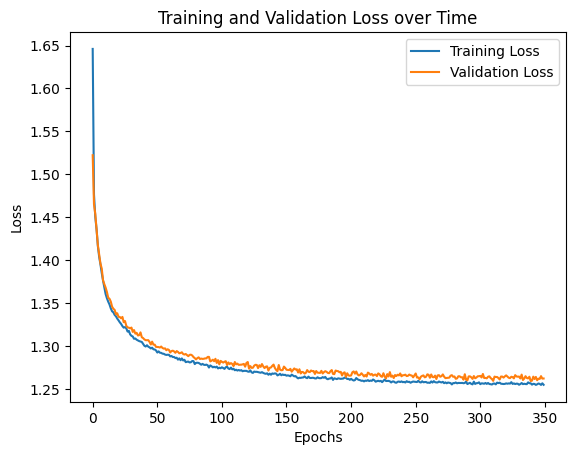

In [14]:
# Plot both training and validation losses
plt.plot(loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

Checking Model's Performance and Visualizing Reconstruction

In [27]:
def visualize_reconstruction(model, dataset, num_samples=10, device='cuda'):
    # model.eval()  # Set the model to evaluation mode
    model.load_state_dict(torch.load('model_ssae_cifar100/best_model_epoch_340.pth'))
    model.eval()

    model.to(device)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        img, label = dataset[i]
        # img, label = img.to(device), label.to(device)
        img = img.view(1, -1).to(device)  # Flatten image
        
        # Forward pass to get the reconstruction
        with torch.no_grad():
            img = img.to(device)
            reconstructed_img = model(img)

        # Reshape images back to 28x28 for visualization
        # img = img.view(28, 28)
        # reconstructed_img = reconstructed_img.view(28, 28)
        
        # Reshape images back to 32x32 with 3 channels for visualization
        img = img.view(3, 32, 32).permute(1, 2, 0).cpu().numpy()  # Convert from (C, H, W) to (H, W, C) format
        reconstructed_img = reconstructed_img.view(3, 32, 32).permute(1, 2, 0).cpu().numpy()  # Reshape and permute back

        
        # Plot original image
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f"Original: {'Normal' if label == 0 else 'Abnormal'}")
        axes[0, i].axis('off')
        
        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_img, cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

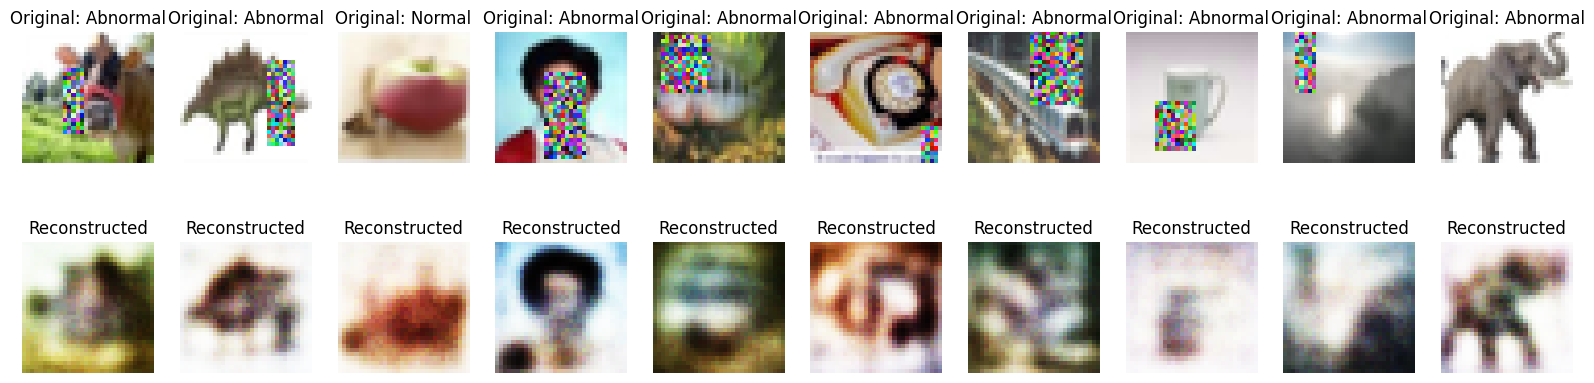

: 

In [28]:
visualize_reconstruction(model, train_dataset, device=device)